<a href="https://www.kaggle.com/code/anirbanacharya/red-wine?scriptVersionId=201116580" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
library(hrbrthemes)
library(dplyr)
library(ggcorrplot)
library(ggplot2)
library(themis)
library(keras)
library(tensorflow)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading required package: ggplot2



Loading required package: recipes




Attaching package: ‘recipes’




The following object is masked from ‘package:stats’:

    step




In [2]:
df = read.csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')
df|>head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


In [3]:
df|>str()

'data.frame':	1599 obs. of  12 variables:
 $ fixed.acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile.acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free.sulfur.dioxide : num  11 25 15 17 11 13 15 15 9 17 ...
 $ total.sulfur.dioxide: num  34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...


In [4]:
normalize = function(column){
  mu = mean(column)
  std = sd(column)
  scale((column-mu)/std)
}

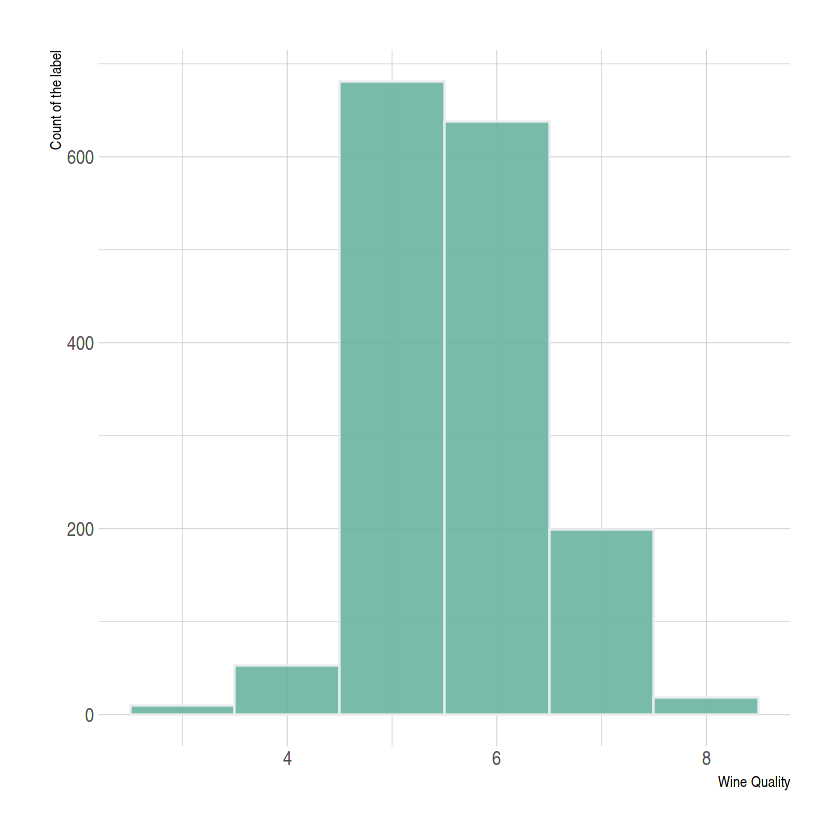

In [5]:
# Let's check the dependent variable distribution:
ggplot(df, aes(x=quality))+
  geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9, bins=6)+
  xlab('Wine Quality')+
  ylab('Count of the label')+
  theme_ipsum()+
  theme(plot.title = element_text(size=15))

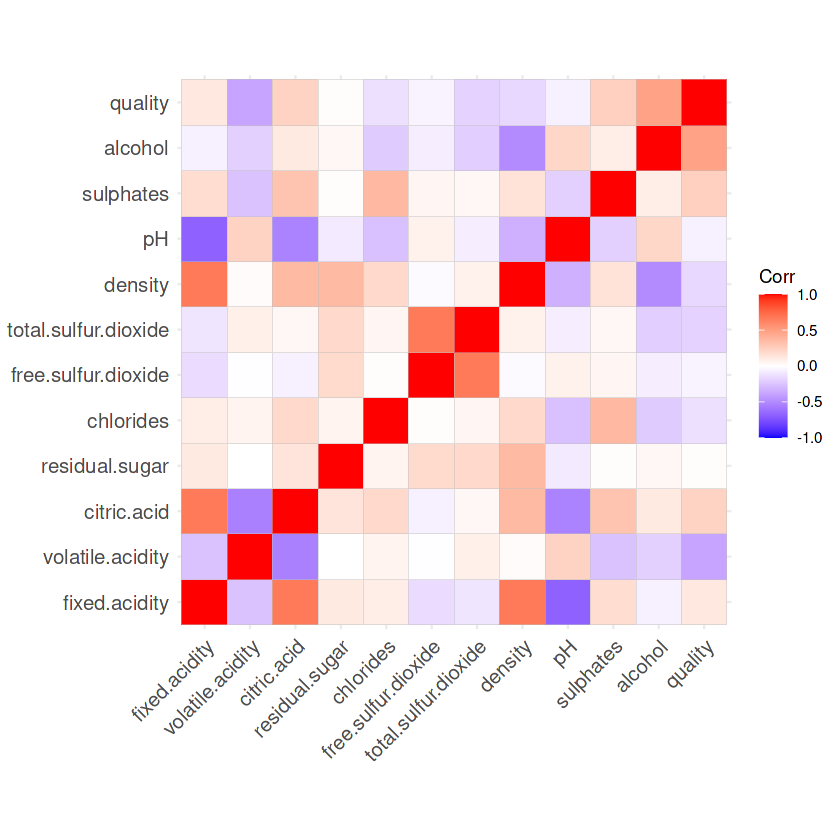

In [6]:
# Let's check the correlation
corr = df|>cor()
ggcorrplot(corr)

In [7]:
new_df = df|>mutate(quality = as.factor(quality)) |> smote(var = 'quality')
filtered_df = new_df |> mutate(id=row_number())
train = filtered_df|>sample_frac(size = 0.8)
test = anti_join(filtered_df, train, by = 'id')

train = train|>select(-id)
test = test|>select(-id)

x_train = train|>select(-quality)|>sapply(normalize)
x_test = test|>select(-quality)|>sapply(normalize)


y_train = to_categorical(as.numeric(train$quality)-1)
y_test = to_categorical(as.numeric(test$quality)-1)
n_inputs = ncol(x_train)
n_outputs = ncol(y_train)

In [8]:
model = keras::keras_model_sequential(layers=list(
  layer_input(shape = c(n_inputs)),
  layer_batch_normalization(),
  
  layer_dense(units=256, activation = 'relu'),
  layer_batch_normalization(),
  
  layer_dense(units=512, activation = 'relu'),
  layer_batch_normalization(),
  
  layer_dense(units=512, activation = 'relu'),
  layer_batch_normalization(),

  
  layer_dense(units=64, activation = 'relu'),
  layer_batch_normalization(),
  

  layer_dense(units=64, activation = 'relu'),
  layer_batch_normalization(),
  
  layer_dense(units=64, activation = 'relu'),
  layer_batch_normalization(),
  
  layer_dense(units=n_outputs, activation = 'relu'),
  layer_batch_normalization(),
  # layer_dropout(rate=0.3),
  
  layer_dense(units = n_outputs, activation = 'sigmoid')
))|>compile(optimizer='adam', loss='categorical_crossentropy', metrics=c('accuracy'), run_eagerly = FALSE)

In [9]:
history = model|>fit(
  as.matrix(x_train),as.matrix(y_train),
  batch_size = 32,
  epochs = 300,
  callbacks = list(callback_early_stopping(patience = 10, restore_best_weights = TRUE, mode = 'max')),
  validation_data = list(as.matrix(x_test), as.matrix(y_test)),
  verbose = 0
  )

history_metrics = data.frame(history$metrics)

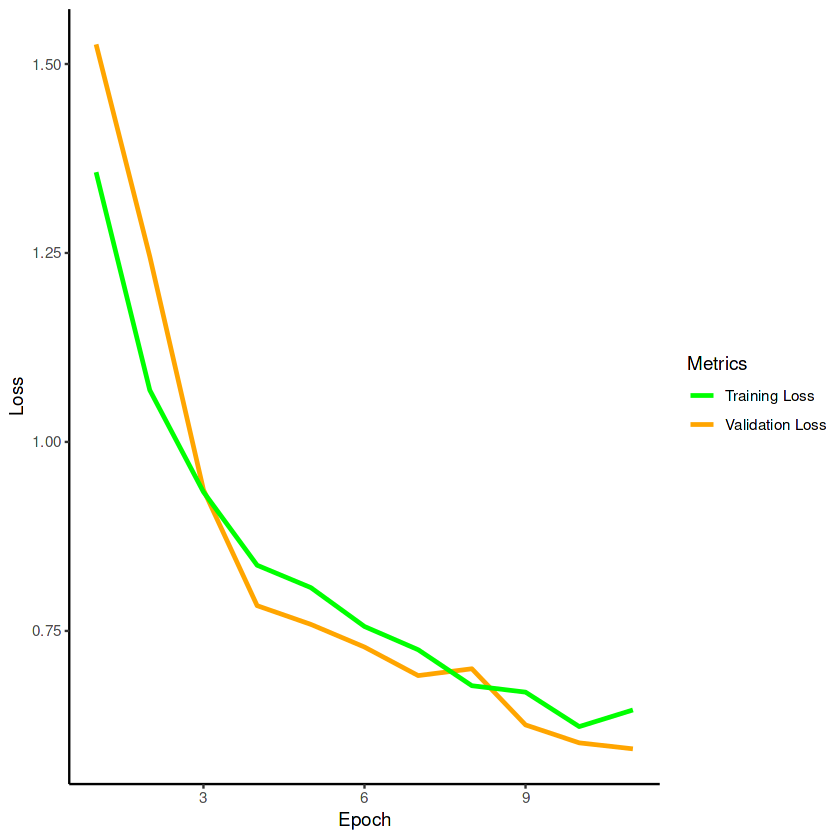

In [10]:
n = nrow(history_metrics)
x_axis = seq(1:n)
ggplot()+
  geom_line(data=history_metrics, mapping = aes(x_axis, val_loss, color = "Validation Loss"), linewidth=1)+
  geom_line(data = history_metrics, mapping = aes(x_axis, loss, color = "Training Loss"), linewidth=1)+
  theme_classic()+
  ylab("Loss")+
  xlab("Epoch")+
  scale_color_manual(values = c("Validation Loss" = "orange", "Training Loss" = "green")) +
  labs(color = "Metrics")

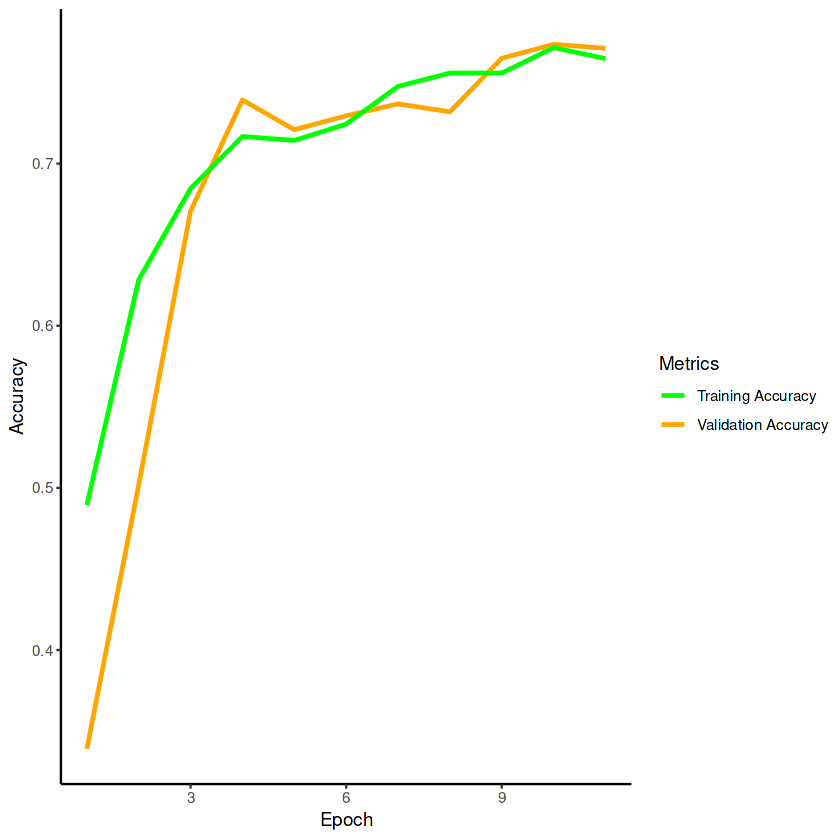

In [11]:
ggplot()+
  geom_line(data=history_metrics, mapping = aes(x_axis, val_accuracy, color="Validation Accuracy"),linewidth=1)+
  geom_line(data=history_metrics, mapping = aes(x_axis, accuracy, color = "Training Accuracy"), linewidth=1)+
  theme_classic()+
  ylab("Accuracy")+
  xlab("Epoch")+
  scale_color_manual(values = c("Validation Accuracy"="orange", "Training Accuracy"="green"))+
  labs(color="Metrics")